## Import packages:

In [48]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import nltk
import gensim
import re
import unicodedata
import datetime
import collections
import random
import time
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib import pylab
from gensim.models.phrases import Phraser
from gensim.models import Phrases
from sklearn.manifold import TSNE
import treetaggerwrapper
import string
import os
import platform
treetaggerPath = str(os.getcwd()) + "/treetagger/" + str(platform.system()) + "/"

In [2]:
treetaggerPath

'/home/francesco/Documents/workspace/gitprojects/TISProject/treetagger/Linux/'

## Load dataset:

In [3]:
trains24 = pd.read_csv("./Dataset/articoliS24O.csv", delimiter="\t")
trainRadiocor = pd.read_csv("./Dataset/articoliRadiocor.csv", delimiter='\t')

colsel_trains24 = trains24[['identificativo', 'body']]

colsel_trainRadiocor = trainRadiocor[['identificativo', 'body']]

colsel_merged = pd.concat([colsel_trains24, colsel_trainRadiocor])

colsel_merged.dropna(inplace=True)
colsel_merged = colsel_merged.reset_index()
colsel_merged = colsel_merged.drop('index', axis=1)

## Clean dataset:

In [4]:
print("SHAPE BEFORE REMOVING DUPLICATES: " + str(colsel_merged.shape)) 
colsel_merged.drop_duplicates(inplace=True) 
print("SHAPE AFTER REMOVING DUPLICATES: " + str(colsel_merged.shape))

colsel_merged['body'] = colsel_merged['body'].apply(lambda x : str(x).lower())
colsel_merged['body'] = colsel_merged['body'].str.replace(r'(\\)+[a-z]\{[0-9]+\}','')
colsel_merged['body'] = colsel_merged['body'].str.replace('\n','')

#how to deal with times?
#colsel_merged['body'] = colsel_merged['body'].str.replace('[0-9]+\.[0-9]+','')

#handle percentages
colsel_merged['body'] = colsel_merged['body'].apply(lambda x: str(re.sub(r'([0-9]+)((\,|\.)[0-9]+)?((\s)?per(\s)?cento|(\s)?%)',r'\1_percento',str(x))))

#removing contracted articles and prepositions
colsel_merged['body'] = colsel_merged['body'].apply(lambda x: str(re.sub(r'[a-zA-Z]+\’',r' ',str(x))))
colsel_merged['body'] = colsel_merged['body'].apply(lambda x: str(re.sub(r'[a-zA-Z]+\'',r' ',str(x))))
colsel_merged['body'] = colsel_merged['body'].str.replace(r'(il)?( )?sole( )?24( )?ore','sole24ore')
#colsel_merged['body'] = colsel_merged['body'].str.replace('(milion(i|e)|miliard(i|o)|euro)','')


#replace abbreviation
colsel_merged['body'] = colsel_merged['body'].str.replace('p/e','price_earnings_ratio')
colsel_merged['body'] = colsel_merged['body'].str.replace(r'mld', 'miliardi')
colsel_merged['body'] = colsel_merged['body'].str.replace(r'mln', 'milioni')

#taking in account quanties
colsel_merged['body'] = colsel_merged['body'].str.replace(r'milione', 'milioni')
colsel_merged['body'] = colsel_merged['body'].str.replace(r'miliardo', 'miliardi')
colsel_merged['body'] = colsel_merged['body'].apply(
    lambda x: re.sub(r'([1-9]+)(\,|\.)[0-9]+ ?((milion(i|e)|miliard(i|o)|mila|euro))', r'\1 \3', x))
#colsel_merged['body'] = colsel_merged['body'].apply(lambda x: re.sub(r'([1-9]+)((,|.)([0-9]+) )?mila', r'\1', x)+'000')


#remove useless endings
colsel_merged['body'] = colsel_merged['body'].str.replace(r'\(c.fe.\)','')
colsel_merged['body'] = colsel_merged['body'].str.replace(r'((\()?( )?sole24ore (radiocor)?( plus)?( )?(\))?.\-.*?)\-','')
colsel_merged['body'] = colsel_merged['body'].str.replace(r'(continua (da )?pagina [0-9]+)© riproduzione riservata(continua (da )?pagina [0-9]+)', '')
colsel_merged['body'] = colsel_merged['body'].str.replace(r'((© )?riproduzione riser(vata)?).*','')

#format urls
colsel_merged['body'] = colsel_merged['body'].str.replace(r'(www\.|http\:\/\/|https\:\/\/|\.com|\.net|\.org|\.it|@[a-zA-Z]+)','')
colsel_merged['body'] = colsel_merged['body'].str.replace(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?','')  

#format dots for pos_tagging, done in order to mess up with urls!
colsel_merged['body'] = colsel_merged['body'].str.replace(r':',' : ')
colsel_merged['body'] = colsel_merged['body'].str.replace(r'[a-zA-Z]+\'',' ')
#colsel_merged['body'] = colsel_merged['body'].apply(lambda x: re.sub(r'([1-9]+)\.([0-9][0-9][0-9])', r'\1', x)+'000')
#colsel_merged['body'] = colsel_merged['body'].apply(lambda x: re.sub(r'([0-9]+)(\.|\,)\D',r'\1 ', x))
colsel_merged['body'] = colsel_merged['body'].str.replace(r'.','. ')
colsel_merged['body'] = colsel_merged['body'].apply(lambda x: re.sub(r'([a-z]+)\.([a-z][a-z]+)', r'\1. \2', x))
colsel_merged['body'] = colsel_merged['body'].apply(lambda x: re.sub(r'([a-z]+)\.\D',r'\1 ', x))
colsel_merged['body'] = colsel_merged['body'].str.replace(r'( )+',' ')

#adjusted html tags cleaning! 2 is the magic number
for _ in np.arange(2):
    colsel_merged['body'] = colsel_merged['body'].apply(lambda x: str(BeautifulSoup(x,"lxml").text))
    
#escaping &
colsel_merged['body'] = colsel_merged['body'].apply(lambda x: str(re.sub(r'( )?\&( )?','and',str(x))))


#removing unprintable unicode
colsel_merged['body'].replace('\u200e','',regex=True,inplace=True)

SHAPE BEFORE REMOVING DUPLICATES: (10150, 2)
SHAPE AFTER REMOVING DUPLICATES: (9283, 2)


x= 'santander.fca'
y= re.sub(r'([a-z]+)\.([a-z][a-z]+)', r'\1. \2', x)
y

x= '8.2 mila'
y= re.sub(r'([1-9]+)((,|.)([0-9]+) )?mila', r'\1', x)+'000'
y

ty = 'Il margine lordo industriale si è poi attestato a 90,8 milioni (+3,1%) e l’ebitda è salito a 37,4 milioni (+2,9%). Così l’utile netto ha segnato un incremento del 7,2% a 1,3 milioni (1,2 milioni al primo trimestre del 2015'
re.sub(r'([1-9]+)\,[0-9]+ ?((milion(i|e)|miliard(i|o)|euro))', r'\1_\2', ty)

In [5]:
tmp= colsel_merged[colsel_merged['identificativo']=='FM20151009036ACmwyfCB']['body'].values
print(tmp)

[ 'pietro scott jovane lascia la poltrona di amministratore delegato di rcsmedia group al termine di una giornata fitta di incontri e partita in prima mattinata con il summit con le banche creditrici per la rinegoziazione del debito, il consiglio di amministrazione del gruppo editoriale ha comunicato uscita «consensuale» di scott jovane a partire dal prossimo 15 ottobre e assegnazione delle deleghe di jovane ad interim al presidente maurizio costa «il cda di rcs mediagroup - si legge in una nota - ha preso atto della volontà ad pietro scott jovane di lasciare il proprio incarico, ritenendo concluso un ciclo della vita aziendale e manifestando intenzione di intraprendere un nuovo percorso professionale».  inoltre il consiglio ha comunicato che per la risoluzione del contratto saranno corrisposte 150 mila euro al manager, a cui si sommano 600 mila euro lordi per il patto di non concorrenza il board, iniziato alle 17. 30 in via rizzoli, nella sede centrale di rcs mediagroup, dopo la riuni

In [6]:
print(colsel_merged[colsel_merged['identificativo']=='FM20160827022ADDGKkAB']['body'].values)

[ 'la saga continua nonostante che tutti sappiano come va a finire ma il commissario europeo che si occupa di policy digitale, günther oettinger, non ne è al corrente, evidentemente la saga è quella degli editori che si sentono defraudati di un diritto a causa dei motori di ricerca - cioè di google - che propongono ai lettori qualche riga dei loro articoli insieme ai link per trovarli online oettinger sta studiando una proposta di direttiva che dà agli editori il diritto di chiedere un compenso per quelle righe di testo forse pensa così di apparire come eroe della saga, innovatore che risolve un problema a lungo dibattuto invece, arriva ultimo e dopo che questo genere di soluzione è già fallito in spagna e in germania ma è veramente possibile che non lo sappia? e il vice presidente della commissione, andrus ansip, che conosce il digitale molto meglio di oettinger e che si occupa del mercato unico digitale, non gli ha detto nulla? in realtà, la realtà digitale va troppo veloce per i tem

In [7]:
def clean_tag(tt):
    if(len(tt)<3):
        print(tt[0])
    if(tt[2]=='@card@' or tt[2]=='@ord@'):
        return tt[0]
    else:
        return re.sub(r'[a-z]+\|','',tt[2])

In [8]:
def merge_auxiliary_verbs(current, succ, flag):
    if flag==0:
        if clean_tag(current)=='essere' and succ[1].startswith('VER:'):
            temp = clean_tag(current) + "_" + clean_tag(succ)
            flag = 1
            return temp, flag
        return clean_tag(current), flag
    else:
        flag = 0
        return clean_tag(succ), flag

In [9]:
def pos_tagger_ita(lst):
    corpus = {}
    stopw = set(stopwords.words("italian"))
    puntk = set(string.punctuation)
    direct = set('«') | set('»') | set('“') | set('”')
    rem = stopw | puntk | direct
    tagger = treetaggerwrapper.TreeTagger(TAGLANG='it', TAGDIR=treetaggerPath)
    for txt in lst:
        tagged_txt = []
        tags=tagger.tag_text(txt[1])
        pp_tags= treetaggerwrapper.make_tags(tags)
        flag = 0
        for idx,t in enumerate(pp_tags):
            if idx != len(pp_tags):
                t_succ = pp_tags[(idx + 1) % len(pp_tags)]
                txt_tmp, flag = merge_auxiliary_verbs(t, t_succ, flag)
                if (txt_tmp not in rem):                
                    tagged_txt.append(txt_tmp)
        corpus[txt[0]]= tagged_txt
    return corpus

In [10]:
t1= time.time()
list_corp = colsel_merged[['identificativo','body']].values.tolist()
corp = pos_tagger_ita(list_corp)
print('Lemmatisation done in '+ str(round((time.time()-t1)/60, 0)) + ' min')

Lemmatisation done in 1.0 min


strin ='il mondo delle biotecnologie dove investe bb biotech è complesso un comparto che da una parte richiede specializzazione'
prova = [['fccm', strin ]]
print(prova)
#print(len(len(list_corp[0])))
pos_tagger_ita(prova)

In [11]:
corp_list = list(corp.values())
phrases = Phrases(corp_list)
bigram = Phraser(phrases)

In [12]:
corp['FM20151108016ACcDasOB']

['mondo',
 'biotecnologia',
 'investire',
 'bb',
 'biotech',
 'essere',
 'complesso',
 'comparto',
 'parte',
 'richiedere',
 'specializzazione',
 'altro',
 'seppure',
 'diverso',
 'società',
 'essere',
 'ormai',
 'consolidare',
 'mantenere',
 'caratteristica',
 'frontiera',
 'scientifico',
 'punto',
 'vista',
 'borsistico',
 'andare',
 'maneggiare',
 'cura',
 'certo',
 'lungo',
 'periodo',
 'potenzialità',
 'essere_concretizzare',
 'nasdaq',
 'biotechnology',
 'index',
 'nbi',
 'cioè',
 'paniere',
 'essere_quotare',
 'grande',
 'parte',
 'società',
 'settore',
 'ultimo',
 '10',
 'avere',
 'mettere',
 'segno',
 'incremento',
 'senza',
 'contare',
 're-investimento',
 'cedola',
 '335_percento',
 'chiusura',
 '3',
 '11',
 '2014',
 'sandp500',
 'invece',
 'stesso',
 'arco',
 'tempo',
 'contabilizzare',
 'dividendo',
 'essere_salire',
 '105_percento',
 'insomma',
 'migliore',
 'andamento',
 'nbi',
 'rispetto',
 'wall',
 'street',
 'tradizionale',
 'essere',
 'numero',
 'ciò',
 'dire',
 'per

In [13]:
corp['FM20151009036ACmwyfCB']

['pietro',
 'scott',
 'jovane',
 'lasciare',
 'poltrona',
 'amministratore',
 'delegare',
 'rcsmedia',
 'group',
 'termine',
 'giornata',
 'fitto',
 'incontro',
 'partita',
 'primo',
 'mattinata',
 'summit',
 'banca',
 'creditore',
 'rinegoziazione',
 'debito',
 'consiglio',
 'amministrazione',
 'gruppo',
 'editoriale',
 'avere',
 'comunicare',
 'uscire',
 'consensuale',
 'scott',
 'jovane',
 'partire',
 'prossimo',
 '15',
 'ottobre',
 'assegnazione',
 'delega',
 'jovane',
 'interim',
 'presidente',
 'maurizio',
 'costa',
 'cda',
 'rcs',
 'mediagroup',
 'leggere',
 'nota',
 'avere',
 'prendere',
 'atto',
 'volontà',
 'pietro',
 'scott',
 'jovane',
 'lasciare',
 'proprio',
 'incarico',
 'ritenere',
 'concludere',
 'ciclo',
 'vita',
 'aziendale',
 'manifestare',
 'intenzione',
 'intraprendere',
 'nuovo',
 'percorso',
 'professionale',
 'inoltre',
 'consiglio',
 'avere',
 'comunicare',
 'risoluzione',
 'contratto',
 'essere_corrispondere',
 '150',
 '150',
 'mila',
 'euro',
 'manager',
 's

In [14]:
import csv
with open('cleaned_data.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in corp.items():
        writer.writerow([str(key), (' '.join(value))])

In [15]:
# Import the built-in logging module and configure it so that Word2Vec 
# creates nice output messages
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)
# Initialize and train the model (this will take some time)
from gensim.models import word2vec

In [16]:
tagger = treetaggerwrapper.TreeTagger(TAGLANG='it', TAGDIR=treetaggerPath)
tags=tagger.tag_text('Il mondo delle biotecnologie, dove investe BB Biotech, è complesso. Un comparto che da una parte richiede specializzazione')
treetaggerwrapper.make_tags(tags)

2017-04-12 15:40:00,141 : INFO : lang=it
2017-04-12 15:40:00,143 : INFO : tagdir=/home/francesco/Documents/workspace/gitprojects/TISProject/treetagger/Linux
2017-04-12 15:40:00,144 : INFO : tagbin=/home/francesco/Documents/workspace/gitprojects/TISProject/treetagger/Linux/bin/tree-tagger
2017-04-12 15:40:00,145 : INFO : tagparfile=/home/francesco/Documents/workspace/gitprojects/TISProject/treetagger/Linux/lib/italian-utf8.par
2017-04-12 15:40:00,146 : INFO : tagopt=-token -lemma -sgml -quiet -no-unknown
2017-04-12 15:40:00,147 : INFO : taginencoding=utf-8
2017-04-12 15:40:00,149 : INFO : tagoutencoding=utf-8
2017-04-12 15:40:00,150 : INFO : taginencerr=replace
2017-04-12 15:40:00,151 : INFO : tagoutencerr=replace
2017-04-12 15:40:00,152 : WARNING : Abbreviation file not found: italian-abbreviations-utf8
2017-04-12 15:40:00,154 : WARNING : Processing without abbreviations file.
2017-04-12 15:40:00,155 : INFO : abbrevfile=None
2017-04-12 15:40:00,171 : INFO : Started TreeTagger from comm

[Tag(word='Il', pos='DET:def', lemma='il'),
 Tag(word='mondo', pos='NOM', lemma='mondo'),
 Tag(word='delle', pos='PRE:det', lemma='del'),
 Tag(word='biotecnologie', pos='NOM', lemma='biotecnologia'),
 Tag(word=',', pos='PON', lemma=','),
 Tag(word='dove', pos='PRO:rela', lemma='dove'),
 Tag(word='investe', pos='VER:pres', lemma='investire'),
 Tag(word='BB', pos='NOM', lemma='BB'),
 Tag(word='Biotech', pos='NOM', lemma='Biotech'),
 Tag(word=',', pos='PON', lemma=','),
 Tag(word='è', pos='VER:pres', lemma='essere'),
 Tag(word='complesso', pos='ADJ', lemma='complesso'),
 Tag(word='.', pos='SENT', lemma='.'),
 Tag(word='Un', pos='DET:indef', lemma='un'),
 Tag(word='comparto', pos='NOM', lemma='comparto'),
 Tag(word='che', pos='PRO:rela', lemma='che'),
 Tag(word='da', pos='PRE', lemma='da'),
 Tag(word='una', pos='DET:indef', lemma='una'),
 Tag(word='parte', pos='NOM', lemma='parte'),
 Tag(word='richiede', pos='VER:pres', lemma='richiedere'),
 Tag(word='specializzazione', pos='NOM', lemma='s

In [17]:
# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 20   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 20          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

In [18]:
print("Training model...")
model = word2vec.Word2Vec(sentences=list(corp.values()), workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling, sorted_vocab=1)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
#model.init_sims(replace=True)


# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
model_name = "300features_40minwords_10context"
model.save(model_name)

2017-04-12 15:40:00,892 : INFO : collecting all words and their counts
2017-04-12 15:40:00,893 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types


Training model...


2017-04-12 15:40:01,179 : INFO : collected 34833 word types from a corpus of 1274549 raw words and 9283 sentences
2017-04-12 15:40:01,180 : INFO : Loading a fresh vocabulary
2017-04-12 15:40:01,210 : INFO : min_count=20 retains 5608 unique words (16% of original 34833, drops 29225)
2017-04-12 15:40:01,211 : INFO : min_count=20 leaves 1173726 word corpus (92% of original 1274549, drops 100823)
2017-04-12 15:40:01,228 : INFO : deleting the raw counts dictionary of 34833 items
2017-04-12 15:40:01,230 : INFO : sample=0.001 downsamples 32 most-common words
2017-04-12 15:40:01,232 : INFO : downsampling leaves estimated 1089728 word corpus (92.8% of prior 1173726)
2017-04-12 15:40:01,233 : INFO : estimated required memory for 5608 words and 300 dimensions: 16263200 bytes
2017-04-12 15:40:01,251 : INFO : resetting layer weights
2017-04-12 15:40:01,351 : INFO : training model with 4 workers on 5608 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=20
2017-04-12 15:40:0

In [19]:
model.most_similar("quotazione")

2017-04-12 15:41:03,500 : INFO : precomputing L2-norms of word weight vectors


[('borsa', 0.9221340417861938),
 ('mta', 0.80739426612854),
 ('ipo', 0.7847241163253784),
 ('essere_quotare', 0.775225818157196),
 ('sbarco', 0.7563447952270508),
 ('star', 0.7480948567390442),
 ('aim', 0.7382375001907349),
 ('listino', 0.7281799912452698),
 ('quotare', 0.7277438044548035),
 ('titolo', 0.698543906211853)]

In [20]:
model.wv.syn0.shape

(5608, 300)

In [22]:
model.vocab['acea'].count

2017-04-12 15:41:06,370 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab


390

In [23]:
model.vocab.keys()

2017-04-12 15:41:06,466 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab


dict_keys(['acea', 'essere', 'pronto', 'giocare', 'partita', 'banda', 'ultralarga', 'stare', 'parlare', 'enel', 'telecom', 'governo', 'rispetto', 'possibilità', 'partecipare', 'posa', 'fibra', 'ottico', 'capitale', 'conferma', 'essere_arrivare', 'ieri', 'alberto', 'irace', 'margine', 'assemblea', 'socio', 'avere', 'approvare', 'bilancio', '2015.', 'contatto', 'aggiunto', 'occupare', 'valutare', 'sinergia', 'possibile', 'prospettiva', 'piano', 'industriale', 'top', 'manager', 'poi', 'auspicare', 'aumento', '20_percento', '40_percento', 'flottante', 'borsa', 'importante', 'attrarre', 'fondo', 'grande', 'investitore', 'unico', 'certezza', 'momento', 'prossimo', 'tappa', 'scattare', 'prima', '31', 'maggio', 'entro', 'data', 'infatti', 'presidente', 'sace', 'ex', 'giovanni', 'dovere', 'venerdì', 'scorso', 'essere_chiudere', '2015', 'cedola', '310', 'milione', 'cassa', 'senza', 'rinnovare', 'organo', 'sociale', 'passaggio', 'testimone', 'dunque', 'servire', 'altro', 'round', 'orientamento', 

In [35]:
x = {}
for word, vocab_obj in model.wv.vocab.items():
    #print('--------------------------')
    #print(word)
    #print(vocab_obj.count)
    x[word] = vocab_obj.count

2017-04-12 15:49:34,992 : WARNING : direct access to syn0 will not be supported in future gensim releases, please use model.wv.syn0


(5608, 300)


5608

In [25]:
model.most_similar('formalmente')

[('bloccare', 0.9083244800567627),
 ('nozze', 0.9024884700775146),
 ('approfondimento', 0.900432825088501),
 ('incrociare', 0.8972514867782593),
 ('mef', 0.8935239315032959),
 ('interessato', 0.8895225524902344),
 ('chigi', 0.8884440660476685),
 ('paletto', 0.886987566947937),
 ('agcm', 0.8788164854049683),
 ('tecnicamente', 0.8779072761535645)]

In [40]:
import operator
sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse= True)
print(sorted_x)

[('avere', 30935), ('milione', 19728), ('essere', 19288), ('euro', 9220), ('gruppo', 9210), ('anno', 7715), ('primo', 6242), ('nuovo', 5737), ('mercato', 5561), ('miliardo', 5179), ('fare', 4845), ('essere_stare', 4515), ('potere', 4439), ('azione', 4422), ('stare', 4313), ('2015', 4255), ('netto', 4184), ('crescita', 4181), ('operazione', 4008), ('società', 3953), ('altro', 3930), ('circa', 3855), ('capitale', 3833), ('pari', 3574), ('parte', 3557), ('mese', 3498), ('italia', 3423), ('fine', 3323), ('2014', 3280), ('1', 3272), ('finanziario', 3208), ('due', 3139), ('ricavo', 3062), ('risultato', 2989), ('prevedere', 2913), ('piano', 2884), ('secondo', 2806), ('dovere', 2805), ('italiano', 2789), ('rispetto', 2777), ('scorso', 2771), ('settore', 2760), ('proprio', 2697), ('grande', 2621), ('investimento', 2618), ('quota', 2591), ('oltre', 2577), ('azienda', 2566), ('ieri', 2564), ('vendita', 2507), ('prezzo', 2496), ('presidente', 2471), ('utile', 2463), ('stesso', 2460), ('aumento', 2

In [45]:
reverse_dictionary = {}
for idx,h in enumerate(sorted_x):
    reverse_dictionary[idx] = h[0]
    
reverse_dictionary

{0: 'avere',
 1: 'milione',
 2: 'essere',
 3: 'euro',
 4: 'gruppo',
 5: 'anno',
 6: 'primo',
 7: 'nuovo',
 8: 'mercato',
 9: 'miliardo',
 10: 'fare',
 11: 'essere_stare',
 12: 'potere',
 13: 'azione',
 14: 'stare',
 15: '2015',
 16: 'netto',
 17: 'crescita',
 18: 'operazione',
 19: 'società',
 20: 'altro',
 21: 'circa',
 22: 'capitale',
 23: 'pari',
 24: 'parte',
 25: 'mese',
 26: 'italia',
 27: 'fine',
 28: '2014',
 29: '1',
 30: 'finanziario',
 31: 'due',
 32: 'ricavo',
 33: 'risultato',
 34: 'prevedere',
 35: 'piano',
 36: 'secondo',
 37: 'dovere',
 38: 'italiano',
 39: 'rispetto',
 40: 'scorso',
 41: 'settore',
 42: 'proprio',
 43: 'grande',
 44: 'investimento',
 45: 'quota',
 46: 'oltre',
 47: 'azienda',
 48: 'ieri',
 49: 'vendita',
 50: 'prezzo',
 51: 'presidente',
 52: 'utile',
 53: 'stesso',
 54: 'aumento',
 55: 'nota',
 56: 'offerta',
 57: 'azionista',
 58: 'oggi',
 59: 'dopo',
 60: 'ultimo',
 61: '2',
 62: 'accordo',
 63: 'dire',
 64: 'cda',
 65: 'valore',
 66: 'banca',
 67: 

In [21]:
#FM20160503034AC2ZryJD
num_points= 400
tsne= TSNE(perplexity=30, n_components= 2, init='pca', n_iter= 5000)
two_d_embeddings= tsne.fit_transform(model.wv.syn0[1:num_points+1, :])

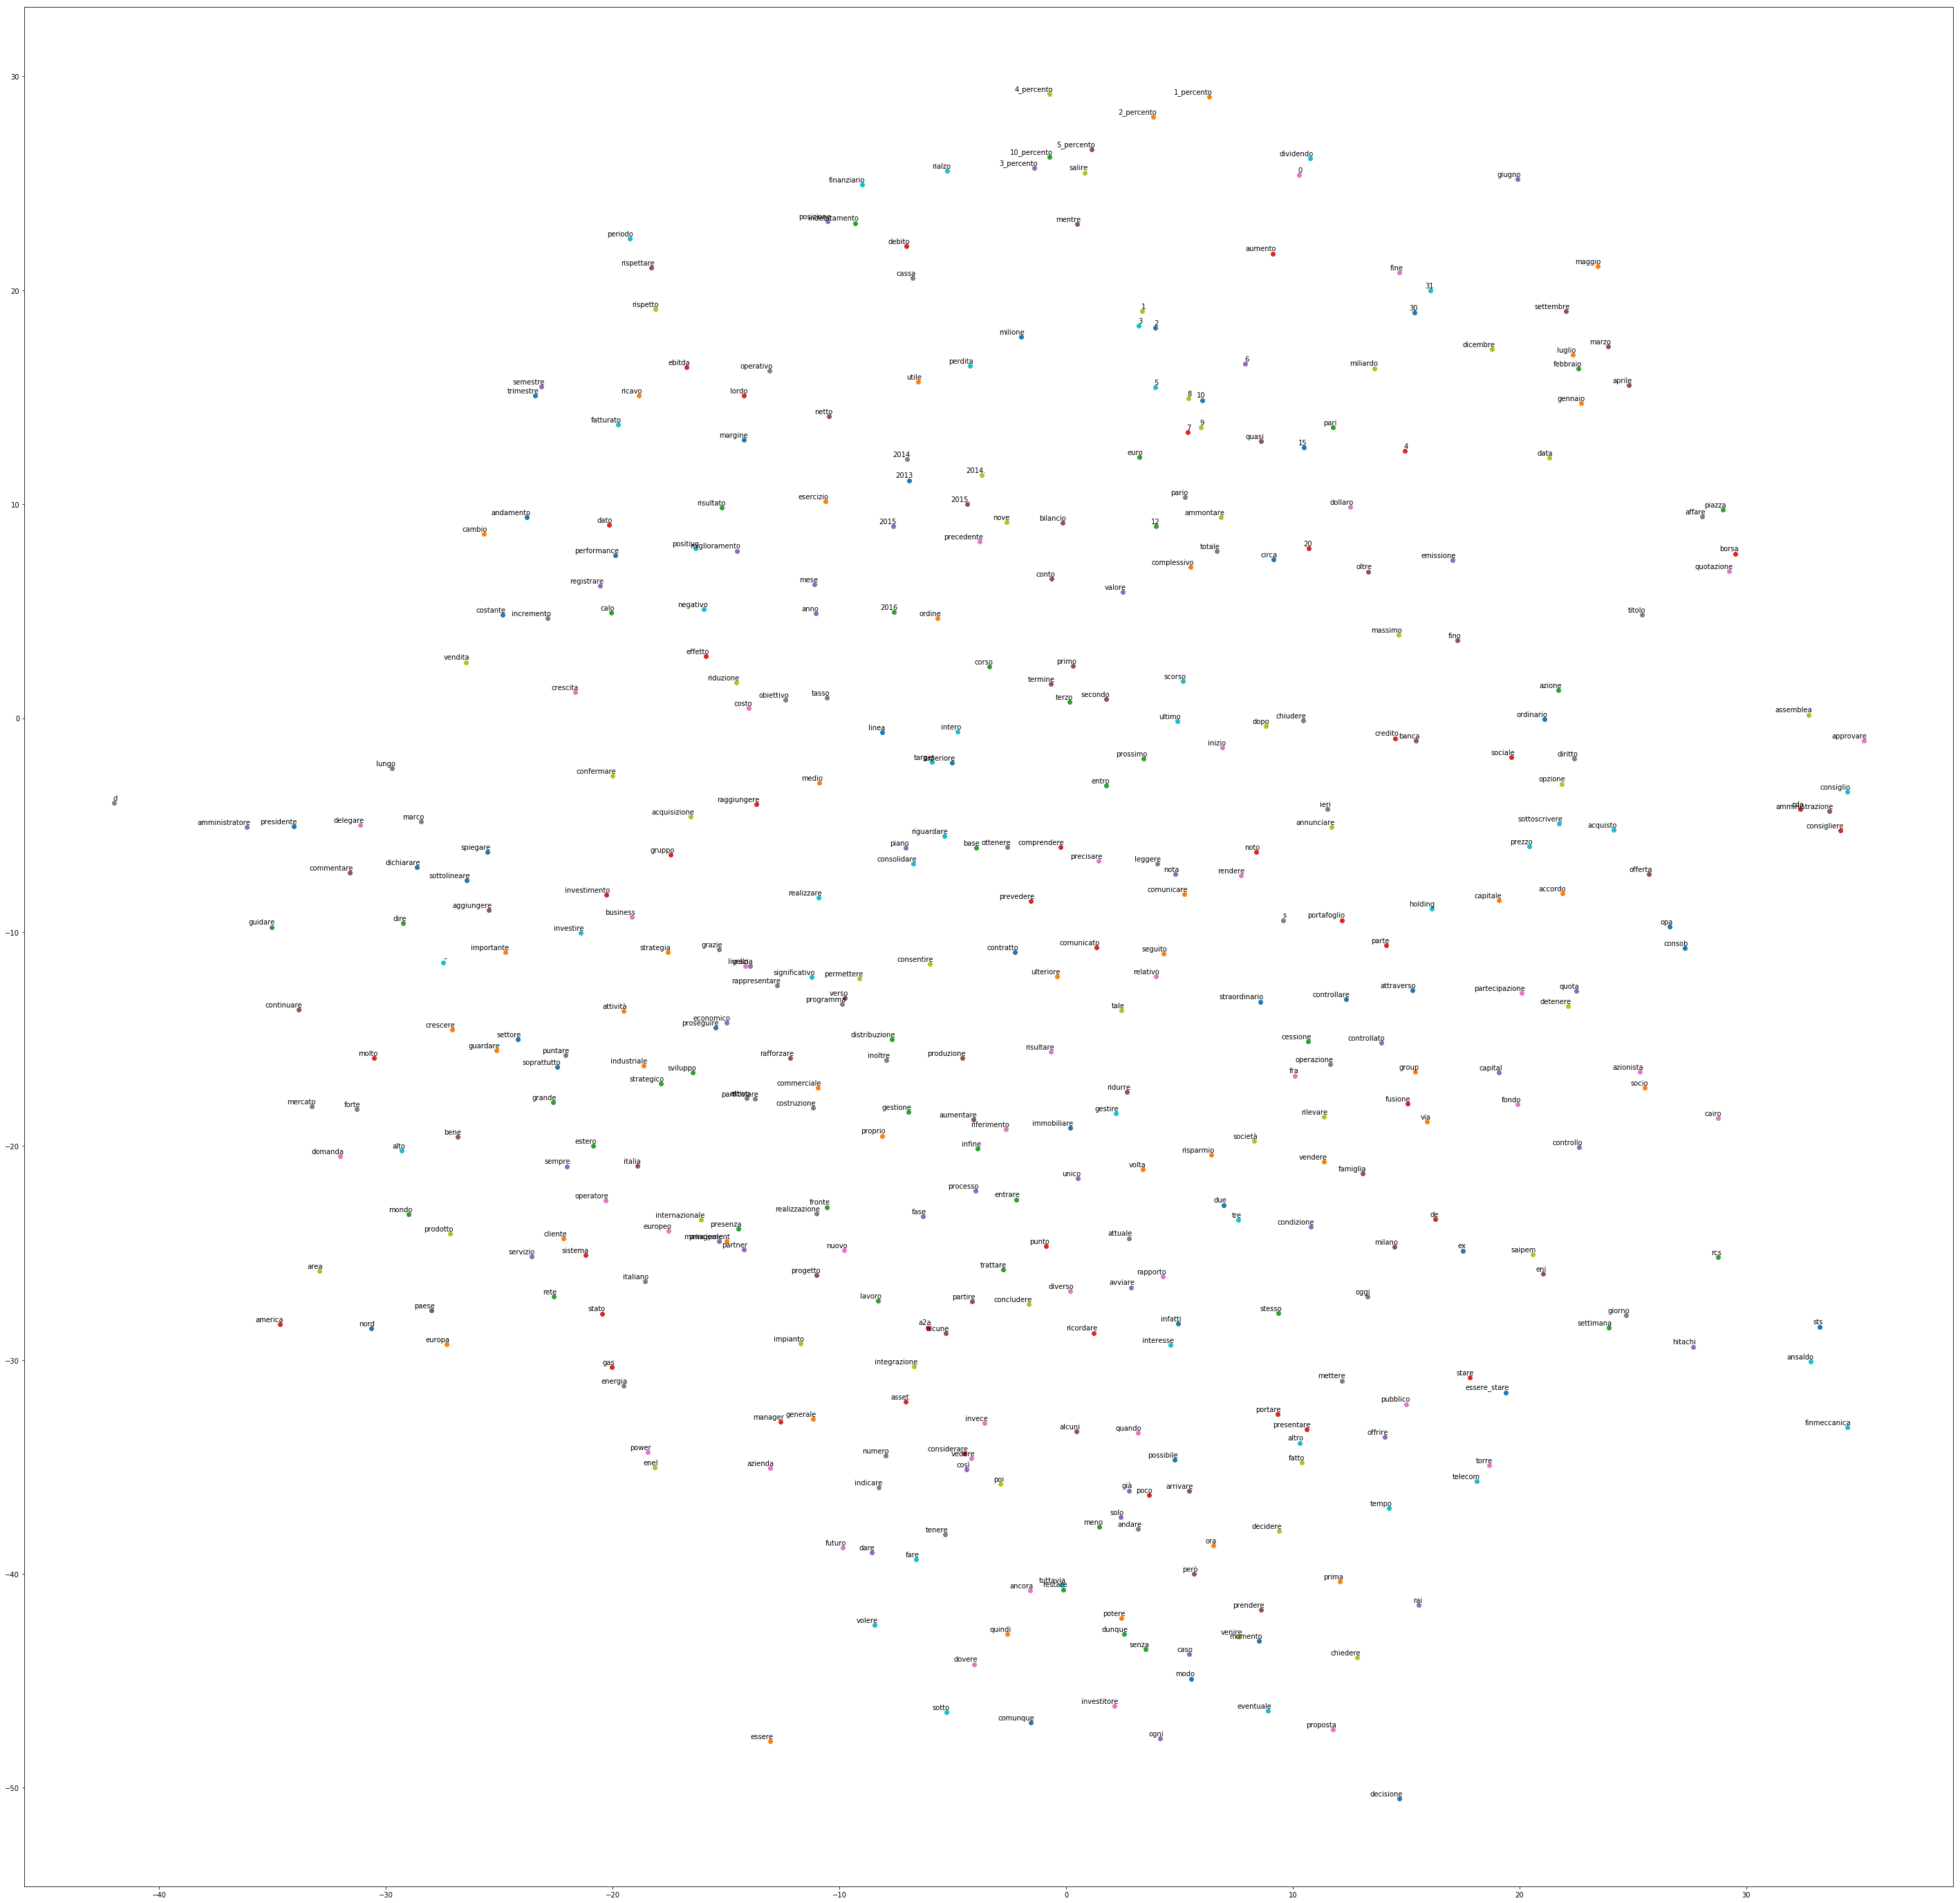

In [50]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(50,50)) # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

In [ ]:
model.syn0.shape

In [ ]:
model.most_similar("biotecnologia")